# Exercise 03: Models, data generation and Forward UQ

In this notebook, we dive into models in CUQIpy, generating noisy data through the data distribution and some forward uncertainty quantification. Finally, we also show how to define new custom models in CUQIpy from either matrices or functions (methods in python).

**Try to run through parts 1 and 2 before working on the optional exercises**

## Learning objectives
* Access and use pre-defined models from the CUQIpy testproblem library.
* Carry out basic operations of models such as forward evaluation.
* Generate noisy forward simulated data from the data distribution.
* Make a CUQIpy model from an existing matrix or function.
* Run a simple forward UQ analysis.

## Table of contents
1. [Test problems](#testproblems)
2. [Basic usage of CUQIpy models](#models)
3. [Generating data](#data)
4. [★ Creating custom CUQIpy models](#custom)
5. [★ Forward UQ](#forwardUQ)

Before getting started we have to import the Python packages we need. Here we also import CUQIpy (cuqi).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("../../CUQIpy")
import cuqi

# 1. CUQIpy test problems<a class="anchor" id="testproblems"></a>
Models in CUQIpy are the link between the solution/parameter, say $\mathbf{x}$, and the data, say $\mathbf{y}$. In their simplest form they are simply a mapping $A: \mathbf{x} \mapsto \mathbf{y}$.

In addition to providing a mapping for the "forward" operation and potentially the adjoint, a CUQIpy model also contains information on the parametrization of its domain and range as well as possible gradients and so on. 

To get a better grasp of the extend of CUQIpy models, let us look at a few examples taken from the testproblem library.

A CUQIpy test problem contains all components specifying an inverse problem, including example data. Most test problems can be configured in different ways. A simple way to work with test problems is to return the main components, namely the forward model, the data and dictionary with problem information. 

## 1.1 Deconvolution in 1D

For example, we can set up a 1D Deconvolution test problem (https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.testproblem/cuqi.testproblem.Deconvolution1D.html) and return the main components by:

In [2]:
model1, data1, probInfo1 = cuqi.testproblem.Deconvolution1D.get_components(dim=64)

c:\Users\Nicolai\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


Calling print around the model gives us some of the most important information about the model:

In [3]:
print(model1)

CUQI LinearModel: Continuous1D(64,) -> Continuous1D(64,). Forward parameters: ['x']


In this case we see that we are working with a LinearModel (linear in the operator sense), which makes sense for the deconvolution problem. We also see that the domain and range are both parametrized as Continous1D with 64 parameters. Finally, we see that the forward parameter is called 'x'.

The problem info typically contains both the exact synthetic signal `exactSolution` from which the data is produced and the exact simulated data `exactData`:

In [4]:
probInfo1

ProblemInfo with the following set attributes:
['exactSolution', 'exactData', 'infoString']
 infoString: Noise type: Additive Gaussian with std: 0.05

The true signal (before blurring) looks like this:

We can plot and compare the clean and noisy data:

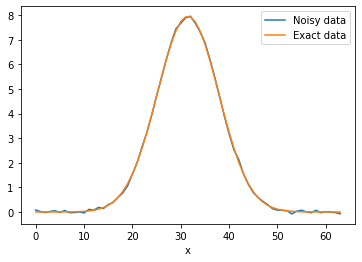

In [5]:
data1.plot(label='Noisy data')
probInfo1.exactData.plot(label='Exact data')
plt.legend()

and easily take a look also at their difference:

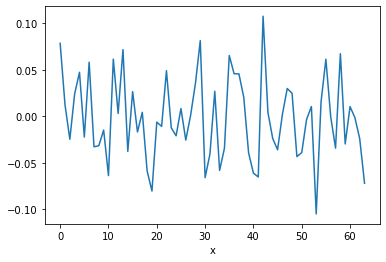

In [6]:
(data1-probInfo1.exactData).plot()

## 1.2 Deconvolution2D: Inverse problem of two-dimensional image deblurring

CUQIpy offers a 2D image deblurring test problem as well, which can be set up in the same way as the 1D problem:

In [7]:
model2, data2, probInfo2 = cuqi.testproblem.Deconvolution2D.get_components()

c:\Users\Nicolai\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


If we take a look at the model we see it is a linear model, now with `Image2D` geometries instead of `Continuous1D` as before - the size corresponds to image of size 128x128 = 16384 pixels:

In [10]:
model2

CUQI LinearModel: Image2D(16384,) -> Image2D(16384,). Forward parameters: ['x']

The exact solution is available and `plot` method displays as an image due to the `Image2D` geometry:

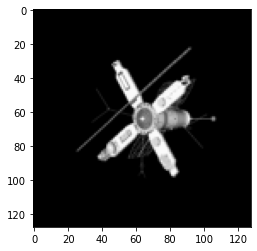

In [11]:
probInfo2.exactSolution.plot()

Similarly the blurred and noisy data, the clean data and their difference (i.e. the added noise) can be displayed as images:

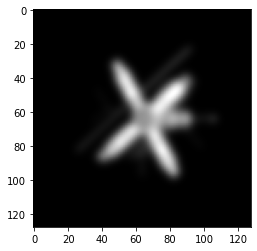

In [12]:
data2.plot()

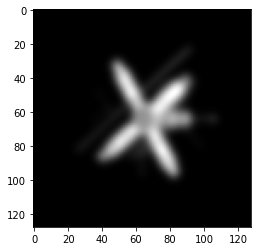

In [13]:
probInfo2.exactData.plot()

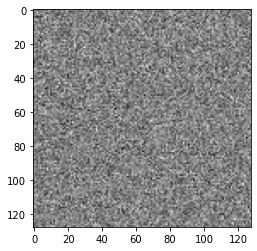

In [14]:
(data2 - probInfo2.exactData).plot()

## 1.3 Heat1D: A model for a PDE-based inverse problem

A completely different test problem is `Heat1D`, which is described by a partial differential equation (PDE), namely the heat equation. The forward model of `Heat1D` maps an initial temperature distribution on an interval to the temperature distribution after a specified amount of time has passed, by solving the 1D heat equation. For more details, see Notebook 5. 

Here, we simply set up the test problem in the same way as before:

In [ ]:
modelH, dataH, probInfoH = cuqi.testproblem.Heat_1D.get_components()

We start by plotting the exact solution, i.e., the true initial temperature distribution over the interval:

In [ ]:
probInfoH.exactSolution.plot()

The data is the noisy observations of the temperature distribution after the time has passed. We plot the data and the exact data as well as their difference:

In [ ]:
dataH.plot()
probInfoH.exactData.plot()

In [ ]:
(dataH - probInfoH.exactData).plot()

We can take a closer look at the model:

In [ ]:
print(modelH)

Again, the domain and range are parametrized as Continous1D with 128 parameters, but the model is now noted as PDEModel.

A PDEModel in CUQIpy is a model where in each forward computation a PDE is 1) assembled, 2) solved and 3) observed. The specifics would depend on the underlying PDE. With that in mind let us have a look at the underlying PDE for this PDEModel.

In [ ]:
modelH.pde

Here we see that the underlying PDE is a time-dependent linear PDE which makes sense for the 1D heat testproblem. We could keep exploring PDEModels, but we leave that to Exercise 05. 

For now, the main message is that the CUQIpy model provides an abstract representation of a forward model of many and different inverse problems, and that CUQIpy offers a collection of test problems containing forward models, data and exact solutions that can be used for demonstration and benchmarking.

# 2 Basic usage of CUQIpy models <a class="anchor" id="models"></a>
In this section we will demonstrate common operations with CUQIpy models. Let us focus on the LinearModel representing the deconvolution problem. 

To simply notation, let us define this model simply as $\mathbf{A}$ (but remember this is a CUQIpy model, not a matrix) and let us define the exact solution as $\mathbf{x}_\mathrm{exact}$.

In [ ]:
A,_,probInfo = cuqi.testproblem.Deconvolution1D.get_components()
x_exact = probInfo.exactSolution

One of the most basic usages of a CUQIpy model is to evaluate the forward map. This is simply done by calling the `.forward` method, or in the case of a LinearModel the short-hand "@" (matrix multiply in Python) can also be used.

In [ ]:
b_exact  = A.forward(x_exact) # Explicitly call the forward method
b_exact  = A@x_exact          # Can also use short-hand for matrix multiply (gives the same result)

Linear model also supports basic operations such as evaluating the adjoint, which can also be done using the numpy-like syntax ".T" for transpose. For example here we apply the adjoint operator of `A` to `b_exact`.

In [ ]:
y = A.adjoint(b_exact)
y = A.T@b_exact

All CUQIpy models also contain information about the parametrization of domain and range in the `domain_geometry` and `range_geometry` attributes.

For example let us take a look at the range geometry of `A`:

In [ ]:
A.range_geometry

When computing the forward, `A`passes its range geometry to the output. We can validate this by inspecting `b_exact`from earlier.

In [ ]:
b_exact.geometry

This allows plotting in the correct geometry immediately after forward computation

In [ ]:
b_exact.plot()

It can be useful to change to domain or range geometries of a model for example to work with different parametrizations. Here we change for example the range geometry of the model to Discrete and see this reflected in the plotting of the computed output:

In [ ]:
A.range_geometry = cuqi.geometry.Discrete(A.range_dim)
A.forward(x_exact).plot()

Note that since we are only interested in generating a plot here, we do not need to store a new variable for b_exact, but rather just immediately call the `plot` method in the same line.

Here we also used `A.range_dim` to get not the range geometry but the dimension of it. Similarly we can ask for the dimension of the domain geometry:

In [ ]:
A.domain_dim

Some LinearOperators simply contain a matrix representing the linear mapping; for those this matrix can be accessed by:

In [ ]:
A.get_matrix()

Finally, models can also be applied to Samples objects for example to evaluate the forward on all samples. This can be used for forward UQ as shown in Section 5 of this notebook.

Given a distribution and some samples generated from it:

In [ ]:
x = cuqi.distribution.Gaussian(np.zeros(A.domain_dim), std=1)

In [ ]:
xs = x.sample(1000)
print(type(xs))
xs.shape

i.e. 1000 samples each of size 128 matching the domain of `A`. We can apply `A` directly to the Samples object:

In [ ]:
ys = A@xs

We plot a couple of selected samples from x:

In [ ]:
xs.plot([100,200,300])

and plot the same samples from y:

In [ ]:
ys.plot([100,200,300])

where we note the computed samples ys = A(xs) have the Discrete geometry as `A` is now equipped with.

#### ★ Try yourself (optional):  
Try modifying the range geometry of `A` to a `Continuous2D` and plotting the result. 

**Hint:** Continuous2D can created with a tuple of integers defining the size of each dimension, e.g. to define a 4 by 4 geometry `cuqi.geometry.Continuous2D((4,4))`

In [ ]:
# This is where you type the code:


# 3. Data generation through data distribution <a class="anchor" id="data"></a>

One of the main tasks when working on numerical experiments for inverse problems is to generate synthetic data (potentially many realizations) to test and validate against. 

In this section, we demonstrate one way this can be achieved by defining the data distribution.

Let us return to the model from the deconvolution testproblem from earlier, and let us assume that the measurement data is affected by additive i.i.d. Gaussian noise. This leads to the inverse problem

$$\mathbf{b} = \mathbf{A}\mathbf{x}+\mathbf{e}.$$

The goal now is to generate examples of observed data $\mathbf{b}$ assuming $\mathbf{e}\sim \mathcal{N}(0,0.05^2)$ given some $\hat{\mathbf{x}}$.

**Note** *Generating noisy data in the above example with additive Gaussian noise is rather straightforward. However, the focus here is to provide a common framework for a much larger variety of models and noise types - exemplified by the Gaussian case.*

First, note that what we are really interested in is sampling from the data distribution $p(\mathbf{b}|\mathbf{x})$ given $\hat{\mathbf{x}}$. This is often written as $p(\mathbf{b}|\mathbf{x}=\hat{\mathbf{x}})$.

 Let us use the phantom from probInfo and extract the model again from the testproblem (just in case some changes were made above)

In [ ]:
n = 50
A, _, probInfo = cuqi.testproblem.Deconvolution1D.get_components(dim=n)
xhat = probInfo.exactSolution

Because the noise is Gaussian, the pdf of the data distribution is simply given by

$$ p(\mathbf{b}|\mathbf{x})\propto \exp\left(\frac{1}{2\cdot (0.05)^2}\|\mathbf{b}-\mathbf{A}\mathbf{x}\|_2^2\right),$$

namely a Gaussian distribution with $\mathbf{A}\mathbf{x}$ as mean and $0.05$ as standard deviation.

The data distribution is conditioned on $\mathbf{x}$ and so we need to represent a conditional distribution in CUQIpy. 

Luckily, when $\mathbf{A}$ is represented by a CUQIpy model this is easy as we simply provide the model in place of $\mathbf{A}\mathbf{x}$ as follows.

In [ ]:
b = cuqi.distribution.Gaussian(mean=A, std=0.05)

Recall from earlier that the model `A` had its forward parameter given by 'x':

In [ ]:
print(A)

If we now inspect the `b` we see that this has become a conditional distribution, conditioned on that same 'x' parameter.

In [ ]:
print(b)

Note that the mean of the Gaussian is really `A*x`, but since `x` is the forward parameter of `A`, this is implied. Work is underway on CUQIpy to enable specifying diretly `A*x` as the mean, but currently this will produce an error that `x` is undefined. A hack to make it work at present is to specify `x` as any distribution of the size of A's domain range and use that as a placeholder. In this way the name of the conditioning variable can also be changed, for example here we use `u` instead of `x`

In [ ]:
u = cuqi.distribution.Gaussian(np.zeros(n), std=1)

and using `u` we can now specify the mean `Au`:

In [ ]:
bu = cuqi.distribution.Gaussian(mean=A@u, std=0.05)
bu

and we see that `u` is now the conditioning variable instead of `x`.

Evaluating a conditional distribution in CUQIpy is simply done by use of the "call" method on Python. That is, for the data distribution we would write `b(x=xhat)` or simply `b(xhat)`.

Evaluating the conditional distribution creates a new distribution, where the conditioning variable is fixed. That is, one can think of the expression `b(x=xhat)` as defining $p(\mathbf{b}|\mathbf{x}=\hat{\mathbf{x}})$. 

Hence to simulate some noisy data, we just provide the conditioning variable `xhat` to the data distribution and then sample.

In [ ]:
b_obs = b(x=xhat).sample()
b_obs.plot();

#### Try yourself (optional):  
The above example may seem like a rather extensive way to generate noisy data when the noise is additive Gaussian (and it is for this simple case!).

Using the CUQIpy framework, try simulating data from the case where the data distribution follows a Laplace distribution with location $\mathbf{A}\mathbf{x}$ and precision $5$. Note that this is no longer additive noise.

In [ ]:
# This is where you type the code:





## 4. ★ Creating custom CUQIpy models <a class="anchor" id="custom"></a>

## 4.1 Defining model from a matrix

Defining a CUQIpy model from a matrix is easy. Suppose we have the matrix representing the forward operator of the following simple linear inverse problem, which is akin to a sudoko puzzle and computed tomography (which is an example, can be replaced by other matrices). Consider a 2x2 square with unknown pixel values, to be determined from the row and column sums:

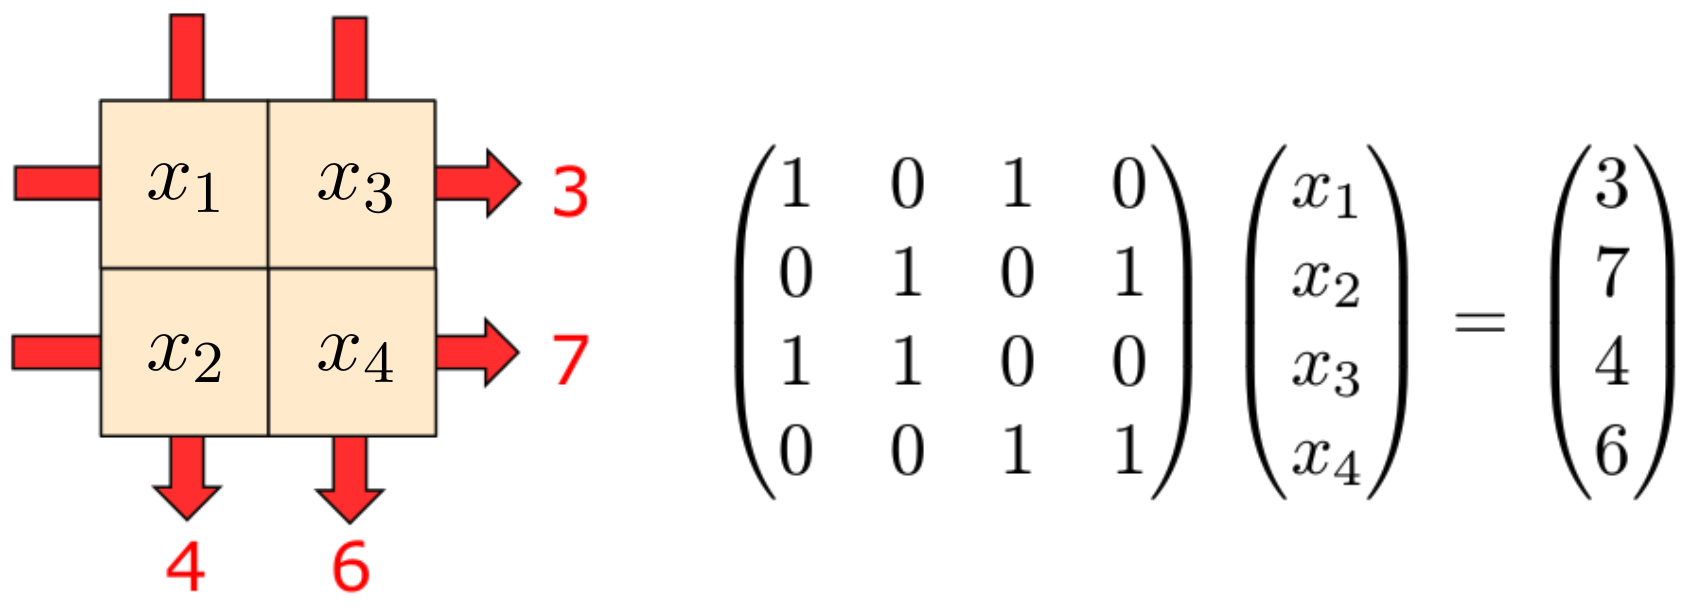

In [ ]:
#Create a numpy matrix to act like a forward model (this matrix can be replaced to represent other problems)
mat = np.array([[1,1,0,0],
               [0,0,1,1],
               [1,0,1,0],
               [0,1,0,1]])

To create a cuqi model represented by this matrix, all we have to do is pass it to the `LinearModel` class from the `model` module in cuqipy as follows.

In [ ]:
model_mat = cuqi.model.LinearModel(mat)
print(model_mat)

Here the range and domain geometry is inferred from the matrix. If we want to we can pass in more explicit information about the range and domain geometries. We can represent the 2x2 grid as an `Continuous2D` geometry:

In [ ]:
geom1 = cuqi.geometry.Continuous2D((2,2))
geom1

We can create an example 2x2 solution as a CUQIarray equipped with the geometry:

In [ ]:
im1 = cuqi.samples.CUQIarray([7,5,3,1], geometry=geom1)
im1

which will allow us to display it nicely:

In [ ]:
im1.plot()
plt.colorbar()

For the row and column sum data we can for the purpose of the example let that be a Discrete geometry:

In [ ]:
geom2 = cuqi.geometry.Discrete(['row1','row2','col1', 'col2'])

We set up and display the observed data from the figure above:

In [ ]:
data = cuqi.samples.CUQIarray([3,7,4,6], geometry=geom2)
data

In [ ]:
data.plot()

We can equip our model with the geometries for its domain and range

In [ ]:
model_mat.domain_geometry = geom1
model_mat.range_geometry = geom2
model_mat

which will allow to apply the forward to an image as if it were a matrix:

In [ ]:
data1 = model_mat@im1
data1

Note the resulting `data1` automatically has the desired geometry.

We can compare the data computed from `im1` against the observed data:

In [ ]:
data1.plot()
data.plot(marker="v")
plt.legend(["Observed data", "Data from im1"])

We can also apply the adjoint using matrix transpose notation:

In [ ]:
adjoint_data = model_mat.T@data1
adjoint_data

### Optional exercise: 
- Try our different values for the four elements of `im1` to find a set that produces the observed data.
- Note there is more than one solution. Can you describe all the solutions?

## 4.2 Defining model from a function
We can also define CUQIpy models from functions. In this case, we must at the minimum provide the dimensions of the range and domain, for example

In [ ]:
#This can be any function representing the forward computation. Here just a random function with 3 inputs and 2 outputs
def my_func(x):
    return np.array([x[0]**2+x[1], x[1]+x[2]])

We could provide any geometry of size 2 for the range and size 3 for the domain - here we use the short-hand integer notation to specify uninformative default geometries that only represent the dimension:

In [ ]:
model_func = cuqi.model.Model(my_func, range_geometry=2, domain_geometry=3)
print(model_func)

Models will work both on simple numpy array and CUQIarrays. Numpy arrays in produces numpy array out:

In [ ]:
in1 = np.array([3.0, 2.0, 1.0])
out1 = model_func(in1)
print(out1)
type(out1)

Passing a CUQIarray in produces a CUQIarray out:

In [ ]:
in2 = cuqi.samples.CUQIarray(in1)
in2

In [ ]:
out2 = model_func(in2)
out2

## 4.3 Linear model from functions

If we have function for both the forward and adjoint, we can also specify a LinearModel from these functions. Here we illustrate by creating a forward and adjoint function from the matrix given earlier

In [ ]:
def mat_forward(x):
    return mat@x

def mat_adjoint(y):
    return mat.T@y

In this case the range and domain dimensions (or geometry) cannot be inferred, so they also need to be defined

In [ ]:
model_linear_func = cuqi.model.LinearModel(forward=mat_forward, adjoint=mat_adjoint, range_geometry=4, domain_geometry=4)
print(model_linear_func)

The new linear model can then be applied to numpy arrays (or CUQIarrays if including geometries):

In [ ]:
z1 = np.array([1., 2., 3., 4.])
z2 = model_linear_func(z1)
z2

and the adjoint function is also available:

In [ ]:
model_linear_func.T(z2)

# 5. ★ Forward UQ <a class="anchor" id="forwardUQ"></a>
In some cases it may be interesting to see the effect a chosen prior has on the data-side, a so-called forward UQ analysis. This can easily be achieved using CUQIpy models and distributions. 

For this case let us assume we have the data created from $\hat{\mathbf{x}}$ earlier, and we want to see if the prior encapsulates the measured data if we push it through forward model (ignoring noise in this case).

To do this we first define our prior and generate some samples from it

In [ ]:
# Number of samples (try changing this)
Ns = 200

# Building blocks for defining Gaussian mean
z = np.zeros(15); o = 0.5*np.ones(20) 

# Prior distribution
x = cuqi.distribution.Gaussian(np.hstack((z,o,z)),0.5)

# Sample prior
xs = x.sample(Ns)

We then plot a credibility interval for the prior and compare with xhat. 

In [ ]:
xs.plot_ci(95)
xhat.plot()
plt.legend(['Credibility interval','Mean of prior','xhat'])

To perform the forward UQ and compare on the data-side, we essentially have to compute the forward for each sample.

This would normally be done with for loop. However, because `xs` is a CUQIpy samples object and `A` is CUQIpy model, we can simply call the forward on the entire samples object (where once again the range geometry is passed from the model to the Samples on the data side).

In [ ]:
bs = A.forward(xs) #Notation A@xs or even A(xs) would also have worked

We then compare the pushed-forward samples with the data generated earlier

In [ ]:
bs.plot_ci(95)
b_obs.plot()
plt.legend(['Credibility interval', 'Mean of push-forward prior', 'Actual data'])